# Import Libaray

In [25]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
library(MASS)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [ ]:
# install.packages("mice")
# library(mice)

In [2]:
diabetes <- read.csv("diabetes.csv")
head(diabetes)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


# Introduction

_Citations to add afterwards_

Diabetes affects approximately 830 million people worldwide, with the majority living in low- and middle-income countries, and more than half live untreated (https://www.who.int/health-topics/diabetes#tab=tab_1). This poses a significant concern because Type 2 diabetes, the most common type, can increase the risk of developing complications, such as cardiovascular disease, stroke, and chronic kidney disease (https://www.heart.org/en/health-topics/diabetes/diabetes-complications-and-risks). Also, the number of people with diabetes and untreated diabetes have been steadily increasing over the past decades, which is why early identification and prevention is important. 

The Pima Indians, an indigenous community, have faced significant challenges in accessing adequate healthcare due to poor resources, low income, and unfavourable economic conditions, which have led to delayed detection and management of chronic illnesses, particularly diabetes (https://diabetesjournals.org/care/article/16/1/216/20743/Determinants-of-Diabetes-Mellitus-in-the-Pima).

Our project focuses on predicting diabetes using health metrics from a dataset by the National Institute of Diabetes and Digestive and Kidney Diseases, made up female patients aged 21+ of Pima Indian heritage. 

Our main question is: Which variables best predict diabetes, and to what extent do these metrics contribute to the likelihood of a diagnosis? 

Another question to understand the depth, is: Which specific predictors (e.g. Glucose, BMI) have the strongest association with diabetes, and how do these align with findings in existing literature?
- _or we can reference a specific literature that says a specific predictor predicts diabetes best_

To answer these questions, we will use logistic regression for binary classifications, exploring valuable insights and creating a model identifying the most significant predictors.

**POSSIBLE RESEARCH:**
- https://www.heart.org/en/health-topics/diabetes/diabetes-complications-and-risks
    - "Type 2 diabetes can increase your risk of developing complications, such as cardiovascular disease, atherosclerosis, stroke, peripheral artery disease and chronic kidney disease."
    - _maybe include this in the intro_
- https://idf.org/about-diabetes/diabetes-facts-figures/
    - International Diabetes Federation
    - "Diabetes facts and figures show the growing global burden for individuals, families, and countries. The IDF Diabetes Atlas (2021) reports that 10.5% of the adult population (20-79 years) has diabetes, with almost half unaware that they are living with the condition."
    - "By 2045, IDF projections show that 1 in 8 adults, approximately 783 million, will be living with diabetes, an increase of 46%."
- https://www.who.int/health-topics/diabetes#tab=tab_1
    - "About 830 million people worldwide have diabetes, the majority living in low-and middle-income countries. More than half of people living with diabetes are not receiving treatment. Both the number of people with diabetes and the number of people with untreated diabetes have been steadily increasing over the past decades."
- https://diabetesjournals.org/care/article/16/1/216/20743/Determinants-of-Diabetes-Mellitus-in-the-Pima
    - Conclusion: "The Pimas and many other American Indian populations suffer from a high incidence of diabetes and its characteristic disabling or fatal complications, and would benefit from continued research on the pathogenesis and prevention of the disease."
- https://dl.acm.org/doi/abs/10.1145/3644116.3644168
    - "Diabetes mellitus is a widespread global health issue with significant consequences and economic burdens. The Pima Indians, an indigenous community residing in certain regions, have faced significant challenges in accessing adequate healthcare due to poor resources, low income, and unfavorable economic conditions. Consequently, these barriers have led to delayed detection and management of chronic illnesses, particularly diabetes."
    - "Key health indicators like age, body mass index (BMI), glucose level, and diabetes pedigree function were considered as predictors. And from the regression tree, glucose level and BMI might be more strongly associated with the likelihood of having diabetes outcome."
    - used binomial logistic regression and regression trees 
    - must get access to it, but we can include this information from the abstract ^^

# Methods and Results

## EDA

In [3]:
# Main developer: Luna 
# view the number of missing values for each variable
missing_values <- colSums(is.na(diabetes))
missing_values 

Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

After viewing missing_values, we can see that there are no missing values for any variable.

However, when we viewed some rows with head(diabetes), there were rows with zero values. 
- The presence of zeros in the dataset may indicate placeholders for missing data, as these values of certain health metrics generally shouldn’t be zero in health data, such as Glucose and Insulin; so, it’s reasonable to consider these zeros as placeholders for missing data. 
- If these are left in the model without treatment, it could lead to bias, especially in a logistic regression model sensitive to extreme values, by skewing distributions (i.e. falsely lower Insulin averages) and weaken the model’s predictive power.

Therefore, we can similarly check for such rows:

In [4]:
# Main developer: Luna 
# these columns are measurements which are generally unlikely to have 0 values (for instance unlike Pregnancies)
columns_with_zeros <- c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")

zero_counts <- colSums(diabetes[columns_with_zeros] == 0)
zero_counts

Glucose BloodPressure SkinThickness       Insulin           BMI 
            5            35           227           374            11

We can now treat these zeros in these key predictor columns as missing values.

I decided to exclude rows with zero values, as these values could distort the analysis.
- _It's worthy to note that a possible issue with this method is that this might reduce our dataset size._

In [5]:
# Main developer: Luna 
# converting the zero values to NA
diabetes2 <- diabetes |>
    mutate_at(vars(all_of(columns_with_zeros)), ~na_if(., 0))

# dropping rows with NA
diabetes_cleaned <- diabetes2 |> drop_na(all_of(columns_with_zeros))
head(diabetes_cleaned)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,1,89,66,23,94,28.1,0.167,21,0
2,0,137,40,35,168,43.1,2.288,33,1
3,3,78,50,32,88,31.0,0.248,26,1
4,2,197,70,45,543,30.5,0.158,53,1
5,1,189,60,23,846,30.1,0.398,59,1
6,5,166,72,19,175,25.8,0.587,51,1


In [6]:
# Main developer: Luna 
# convert Outcome to a factor with levels "0" and "1"
diabetes_cleaned$Outcome <- factor(diabetes_cleaned$Outcome, levels = c(0, 1), labels = c("0", "1"))

# verify and check levels
str(diabetes_cleaned)
levels(diabetes_cleaned$Outcome)

'data.frame':	392 obs. of  9 variables:
 $ Pregnancies             : int  1 0 3 2 1 5 0 1 1 3 ...
 $ Glucose                 : int  89 137 78 197 189 166 118 103 115 126 ...
 $ BloodPressure           : int  66 40 50 70 60 72 84 30 70 88 ...
 $ SkinThickness           : int  23 35 32 45 23 19 47 38 30 41 ...
 $ Insulin                 : int  94 168 88 543 846 175 230 83 96 235 ...
 $ BMI                     : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ DiabetesPedigreeFunction: num  0.167 2.288 0.248 0.158 0.398 ...
 $ Age                     : int  21 33 26 53 59 51 31 33 32 27 ...
 $ Outcome                 : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 1 2 1 ...


[1] "0" "1"

Lastly, viewing summary statistics allows us to gauge potential outliers.

In [7]:
# Main developer: Luna 
summary(diabetes_cleaned)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outco

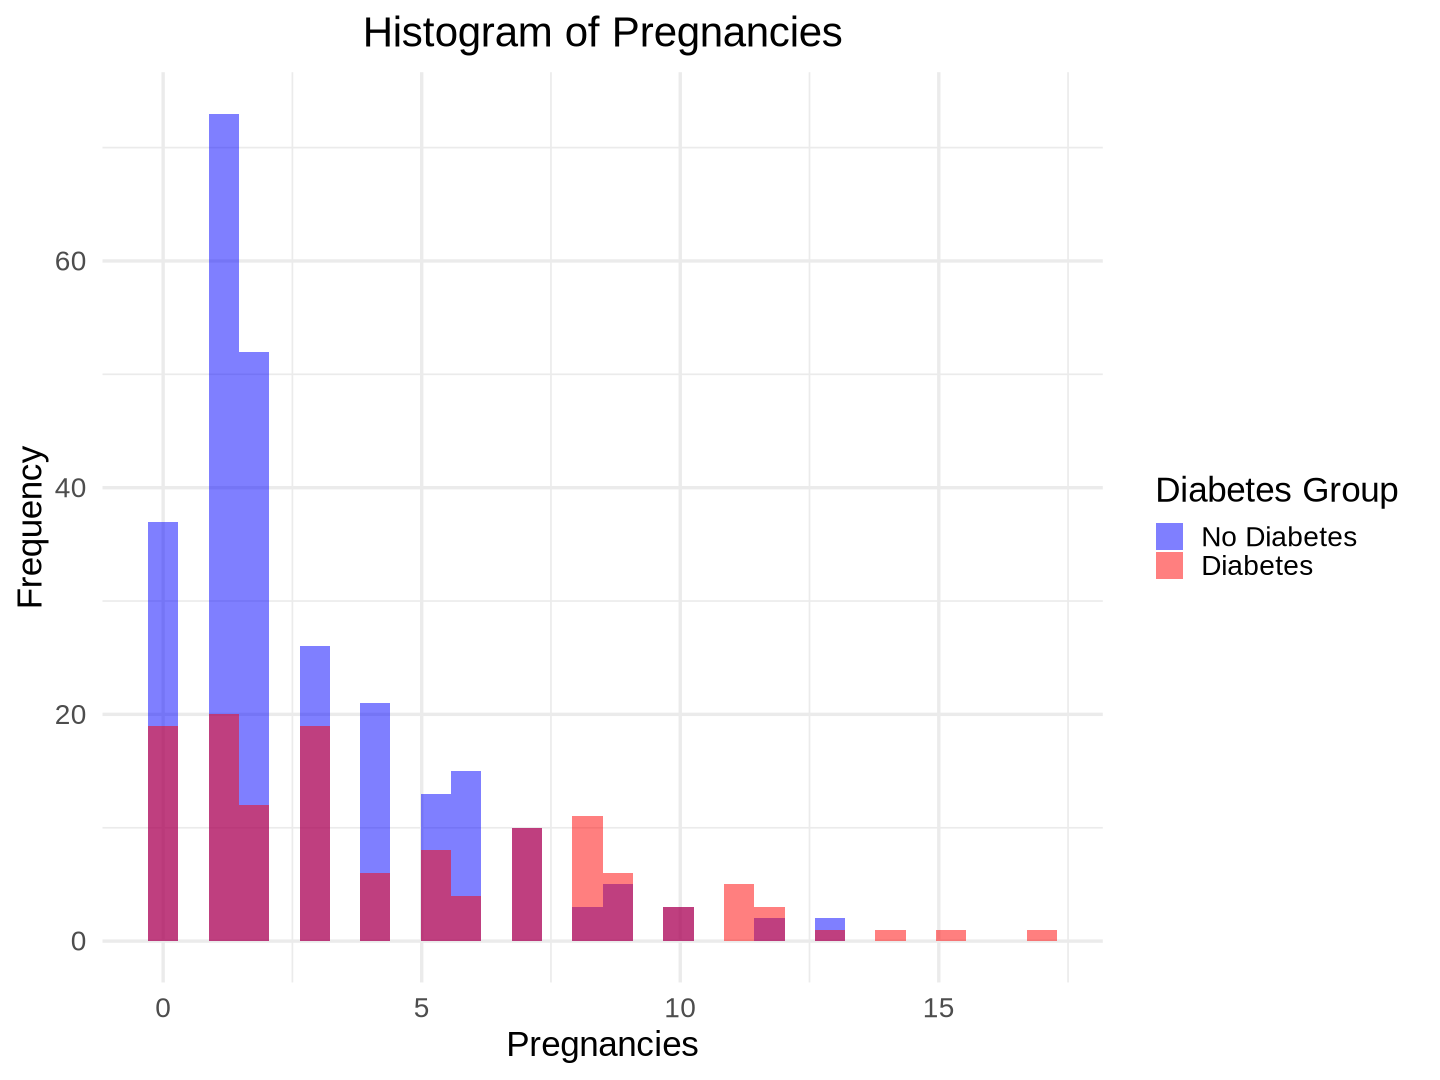

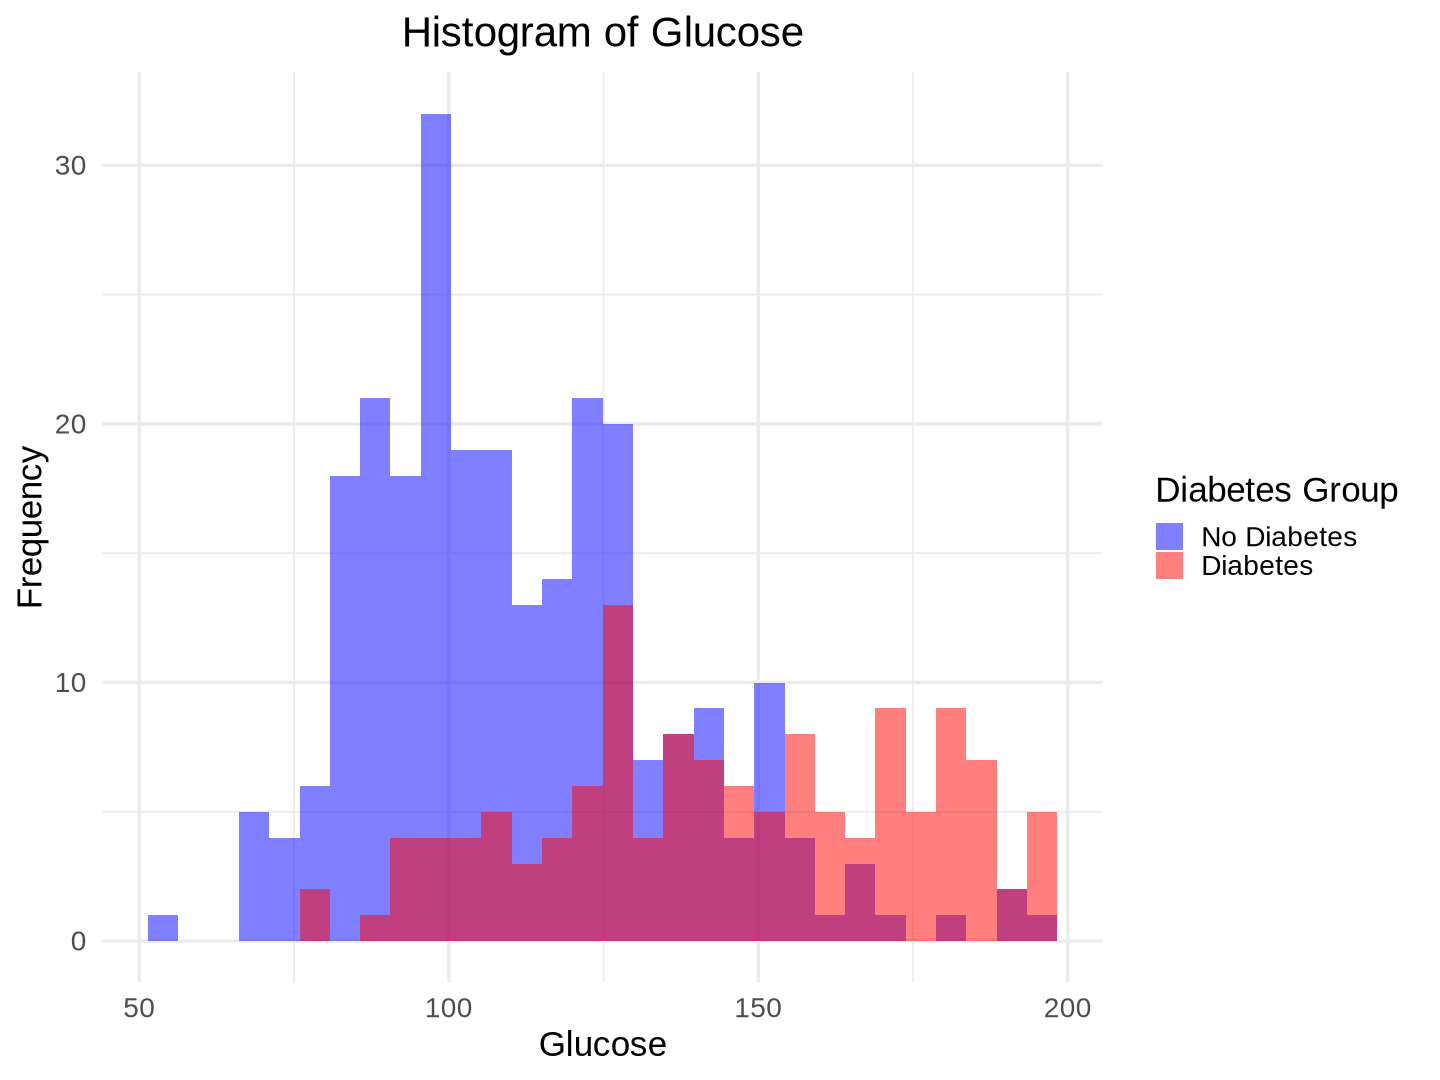

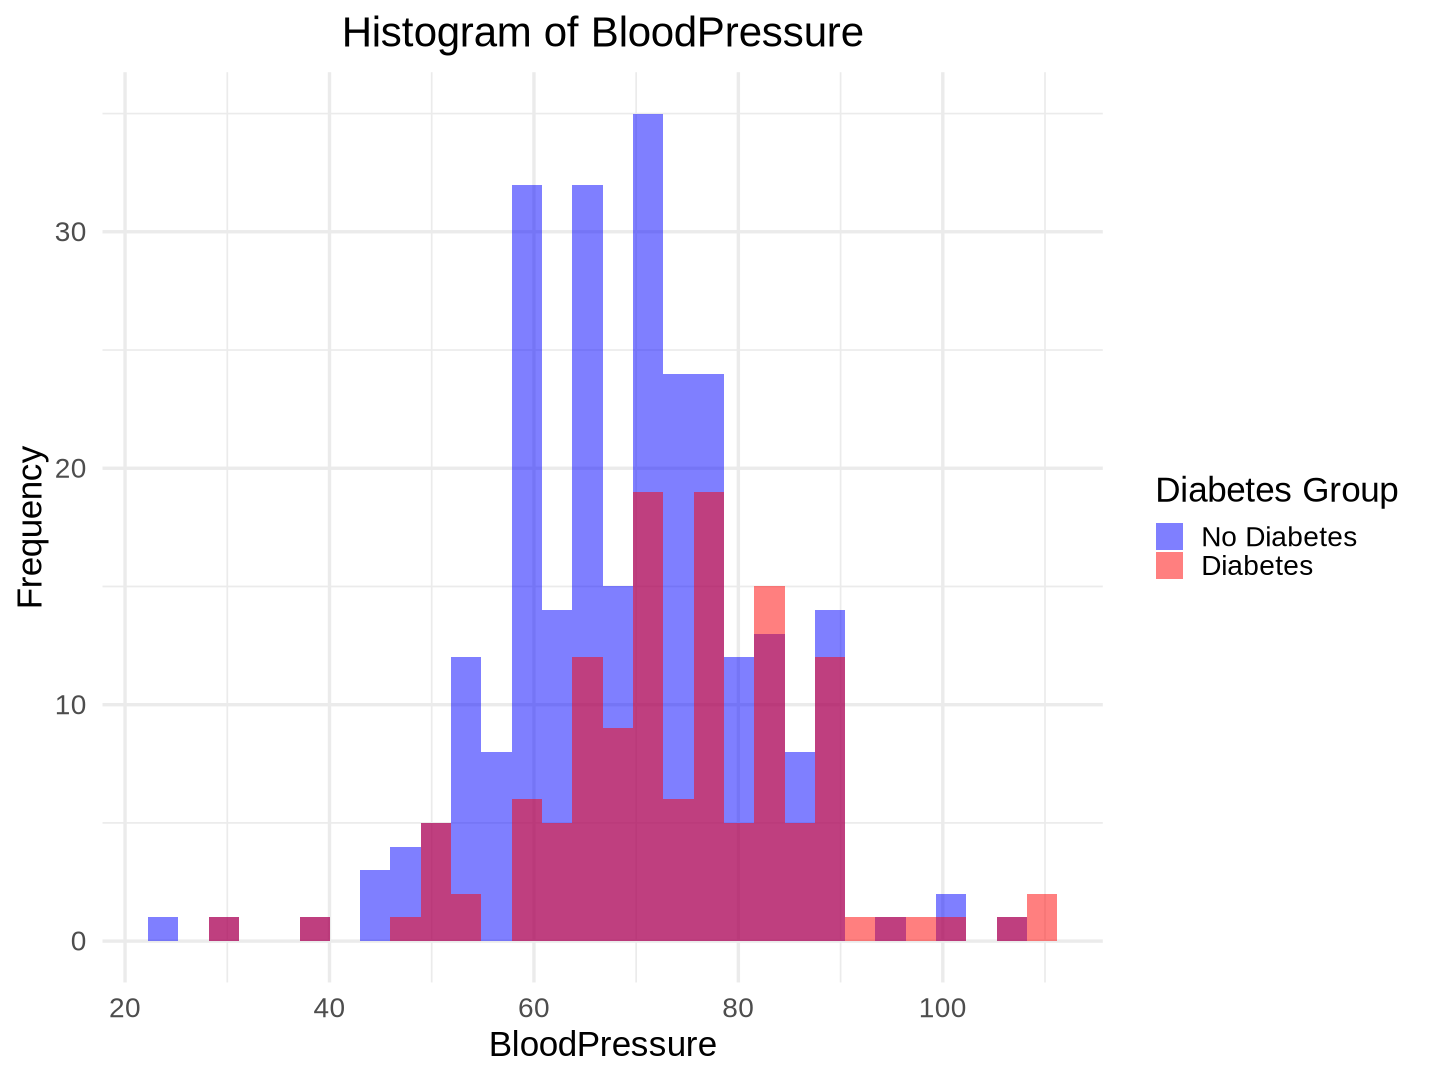

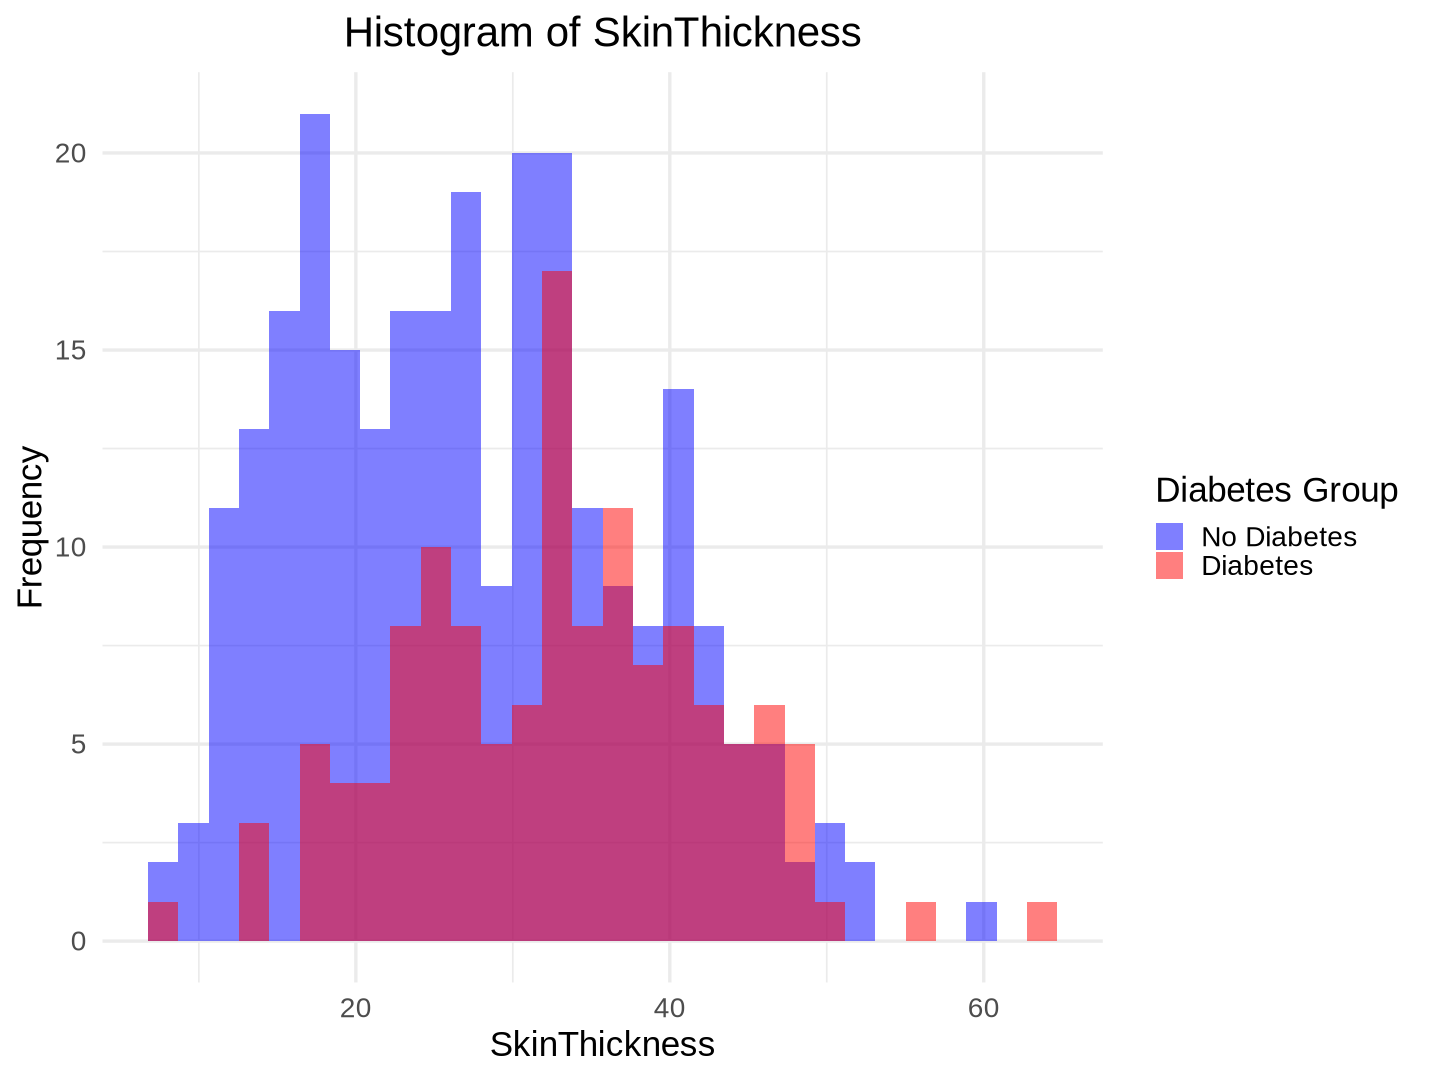

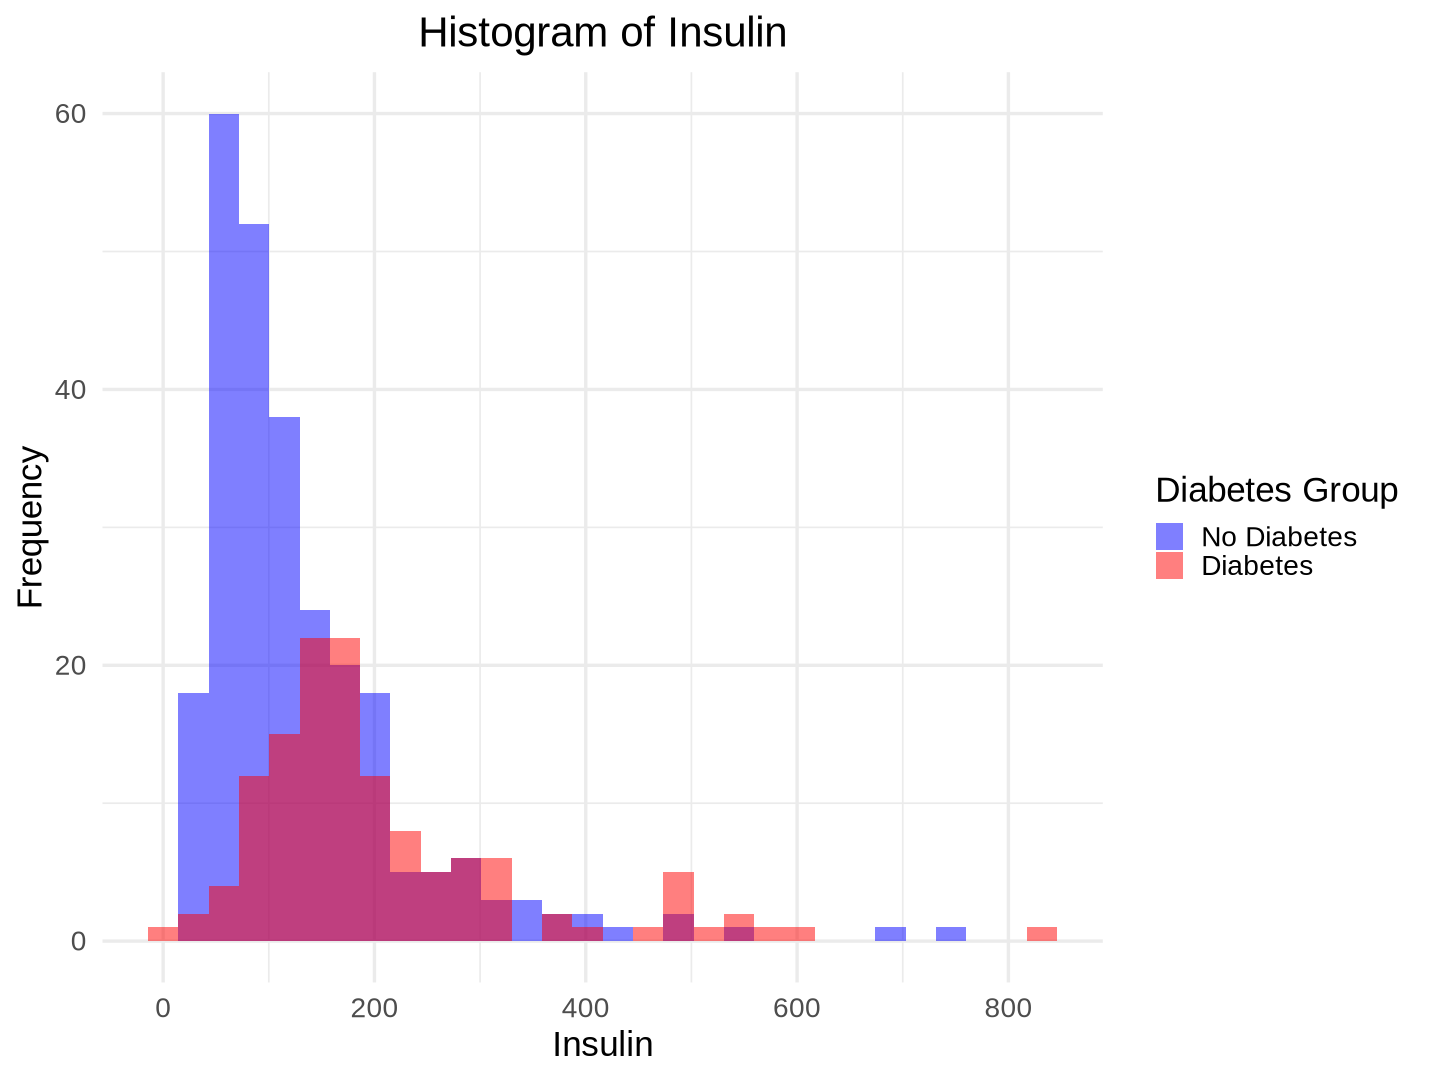

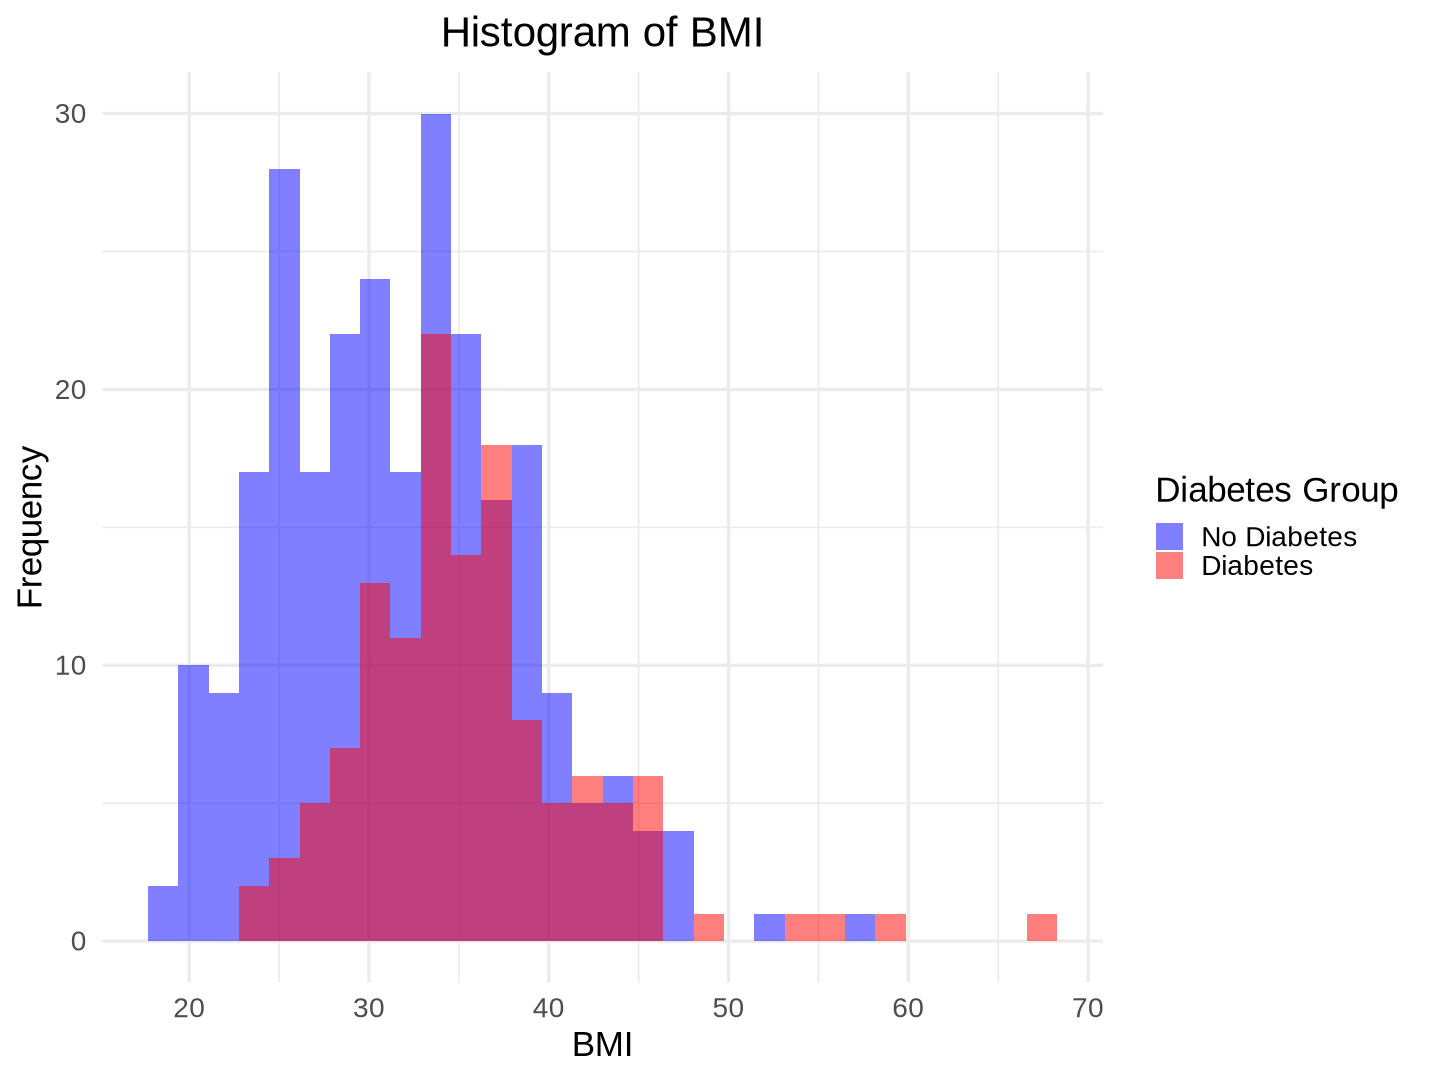

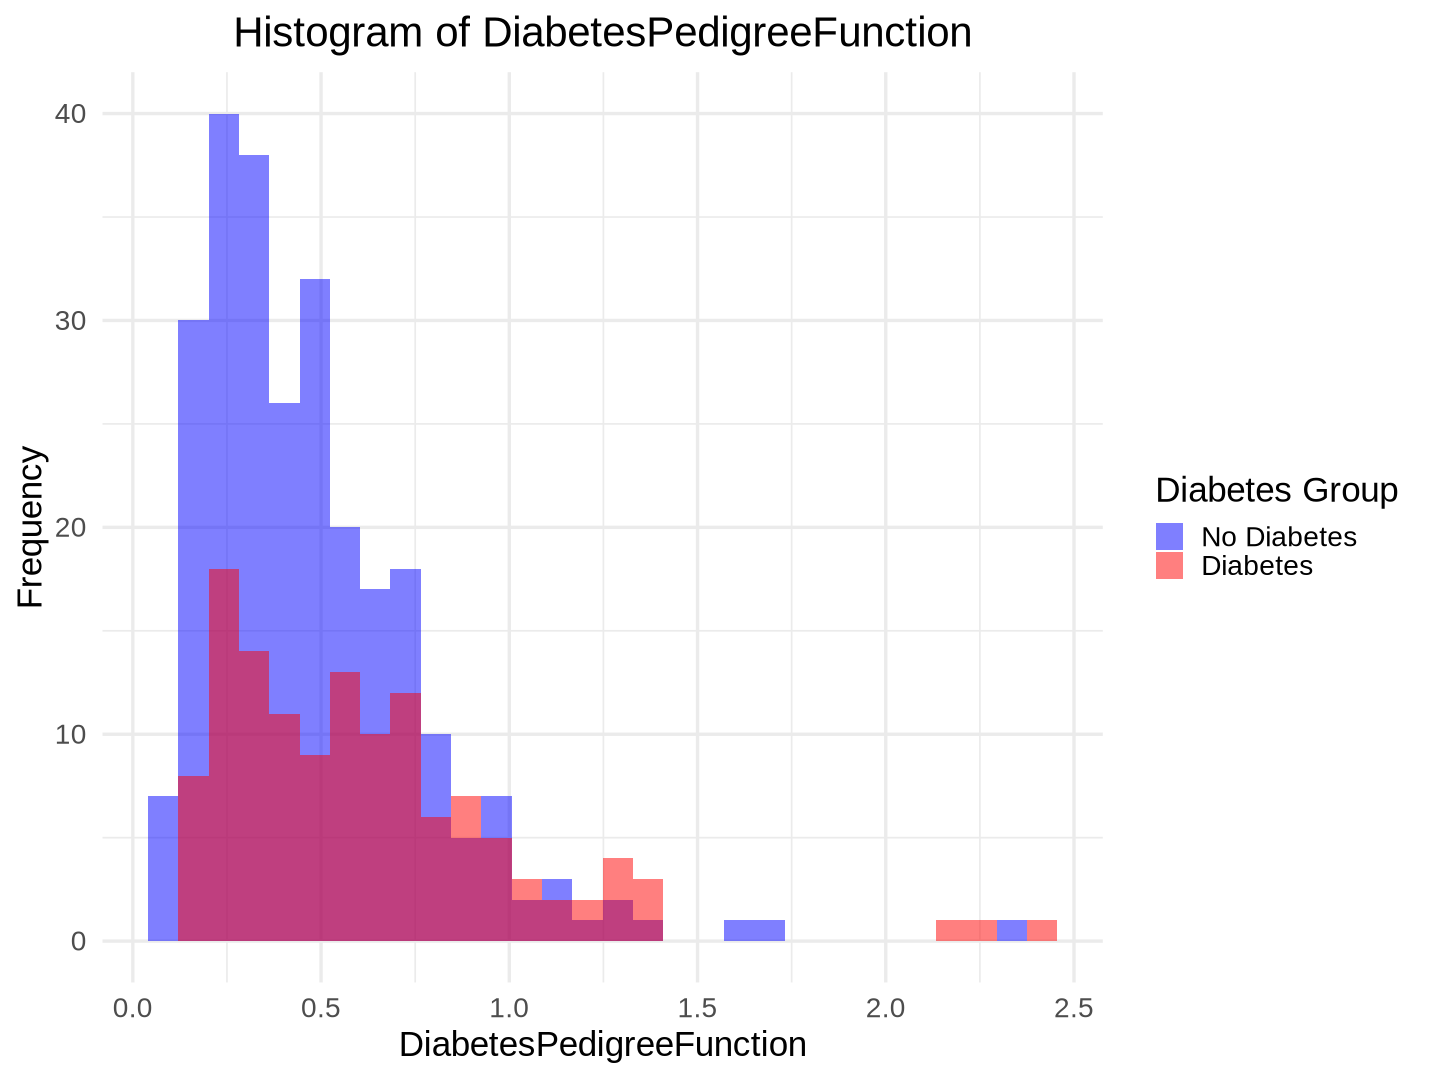

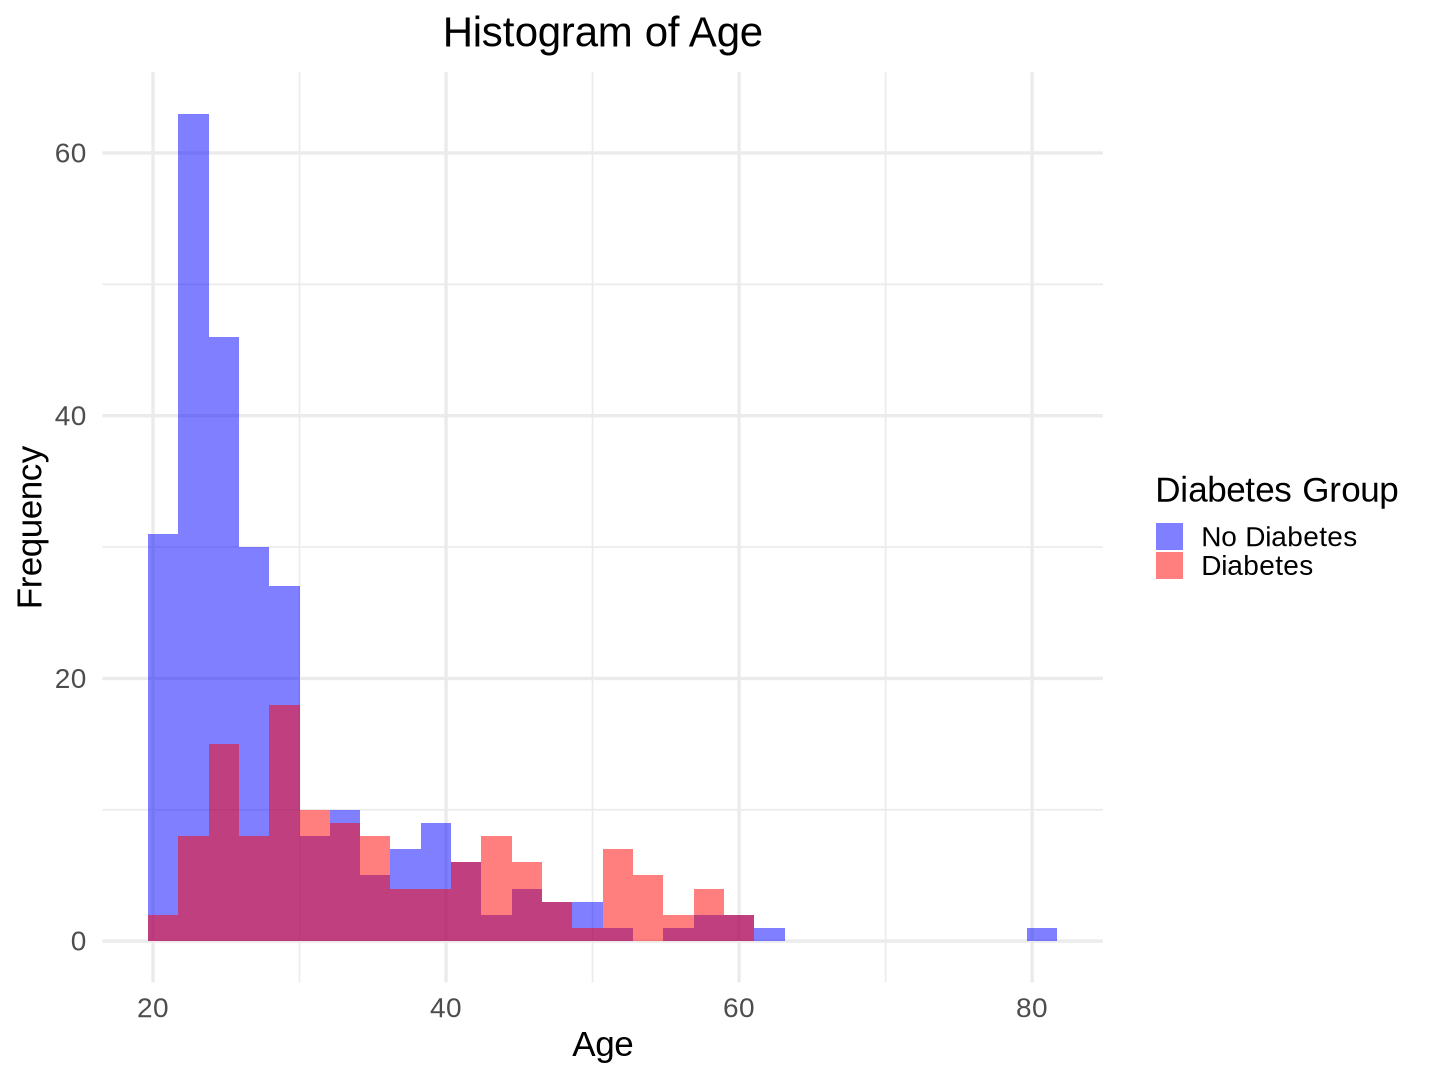

In [8]:
# Main developer: Yulin 
options(repr.plot.width = 12, repr.plot.height = 9)

numeric_cols <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age")

for (feat in numeric_cols) {
  feat_plot <- ggplot(diabetes_cleaned) + 
    geom_histogram(aes(x = get(feat), fill = Outcome), bins = 30, alpha = 0.5, position = "identity") +
    labs(title = paste("Histogram of", feat), x = feat, y = "Frequency") +
    scale_fill_manual(values = c("blue", "red"), labels = c("No Diabetes", "Diabetes")) +
    guides(fill = guide_legend(title = "Diabetes Group")) +
    theme_minimal(base_size = 21) + 
    theme(plot.title = element_text(hjust = 0.5))
  
  print(feat_plot)
}

## Methods: Plan

In [9]:
set.seed(123)

diabetes_sample <-
    diabetes_cleaned %>%
    mutate(id = row_number())

training_diabetes <- 
    diabetes_sample %>%
    slice_sample(prop = 0.70)

testing_diabetes <- 
    diabetes_sample %>% 
    anti_join(training_diabetes, by = "id") %>%
    select(-id)

training_diabetes <-
    training_diabetes |>
    select(-id)

In [10]:
set.seed(123)

diabetes_X_train <- model.matrix(object = Outcome ~ .,
  data = training_diabetes)[, -1]

diabetes_Y_train <- as.matrix(training_diabetes[, "Outcome"])

diabetes_X_test <- model.matrix(object = Outcome ~ .,
  data = testing_diabetes)[, -1]

diabetes_Y_test <- as.matrix(testing_diabetes[, "Outcome"])

In [11]:
set.seed(123)

diabetes_logistic_model <- 
    glm(
        formula = Outcome ~ .,
        data = training_diabetes,
        family = binomial)

ROC_full_log <- 
    roc(
        response = training_diabetes$Outcome, 
        predictor = predict(diabetes_logistic_model, type = "response"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



### Ridge Regression

Best Lambda for Ridge: 0.0500005 


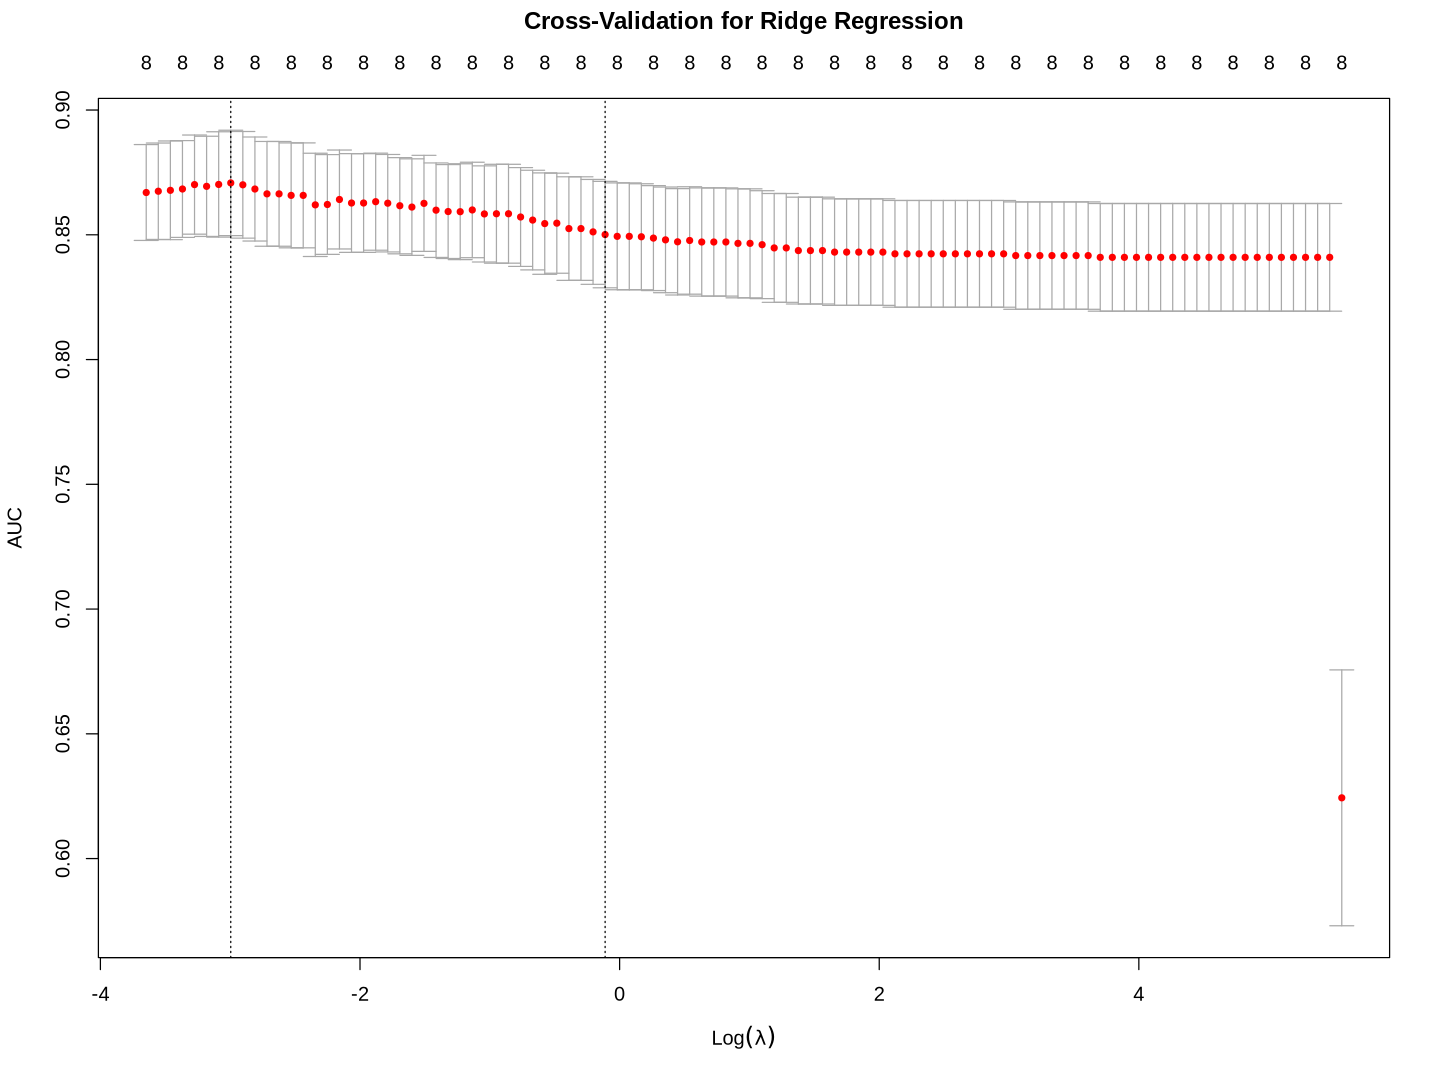

In [12]:
# RIDGE REGRESSION CROSS VALIDATION
set.seed(123)

# Ridge cross-validation
lambda_ridge <- cv.glmnet(
  x = diabetes_X_train, 
  y = diabetes_Y_train,
  alpha = 0,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10
)

plot(lambda_ridge, 
     main = "Cross-Validation for Ridge Regression\n\n")

# extracting the lambda value that gives the maximum AUC
lambda_best_ridge <- lambda_ridge$lambda.min
cat("Best Lambda for Ridge:", lambda_best_ridge, "\n")

In [13]:
# FITTING RIDGE REGRESSION WITH THE BEST LAMBDA
ridge_max_auc <- glmnet(
  x = diabetes_X_train, 
  y = diabetes_Y_train,
  alpha = 0,
  family = "binomial",
  lambda = lambda_best_ridge
)

coef(ridge_max_auc)

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)              -7.9140007446
Pregnancies               0.0121890780
Glucose                   0.0279593360
BloodPressure             0.0018557700
SkinThickness             0.0117086845
Insulin                   0.0009860531
BMI                       0.0484246495
DiabetesPedigreeFunction  0.7656245980
Age                       0.0309212915

In [14]:
# CALCULATE AUC FOR RIDGE

ridge_preds <- predict(ridge_max_auc, newx = diabetes_X_test, type = "response")
ridge_auc <- roc(diabetes_Y_test, as.vector(ridge_preds))$auc
cat("AUC for Ridge Regression:", ridge_auc, "\n")

Setting levels: control = 0, case = 1

Warning message in roc.default(diabetes_Y_test, as.vector(ridge_preds)):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases



AUC for Ridge Regression: 0.8154905 


### Ordinary Logistic Model

In [15]:
# CROSS VALIDATION FOR ORDINARY LOGISTIC MODEL
set.seed(123)
num.folds <- 10

folds <- createFolds(training_diabetes$Outcome, k = num.folds)

regr.cv <- NULL
for (fold in 1:num.folds) {
train.idx <- setdiff(1:nrow(training_diabetes), folds[[fold]])
regr.cv[[fold]] <- glm(Outcome ~ ., data=training_diabetes, subset=train.idx,
                       family="binomial")
    }

pred.cv <- NULL
auc.cv <- numeric(num.folds) 

for (fold in 1:num.folds) {
test.idx <- folds[[fold]]
pred.cv[[fold]] <- data.frame(obs=training_diabetes$Outcome[test.idx],
pred=predict(regr.cv[[fold]], newdata=training_diabetes, type="response")[test.idx])
auc.cv[fold] <- roc(obs ~ pred, data=pred.cv[[fold]])$auc
    }

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [16]:
# Train logistic regression model on the training set
regr.cv[[fold]] <- glm(Outcome ~ ., 
                       data = training_diabetes, 
                       subset = train.idx, 
                       family = "binomial")
  
# Generate predictions for the test set
test_data <- training_diabetes[test.idx, ]
pred_probs <- predict(regr.cv[[fold]], newdata = test_data, type = "response")
  
# Calculate AUC for the current fold
auc.cv[fold] <- roc(test_data$Outcome, pred_probs)$auc

# Average AUC across all folds
cv_ordinary_auc <- mean(auc.cv)
cat("Cross-validation AUC for the ordinary logistic model:", cv_ordinary_auc, "\n")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Cross-validation AUC for the ordinary logistic model: 0.8562745 


### Lasso Regression

Best Lambda for Ridge: 0.007599631 


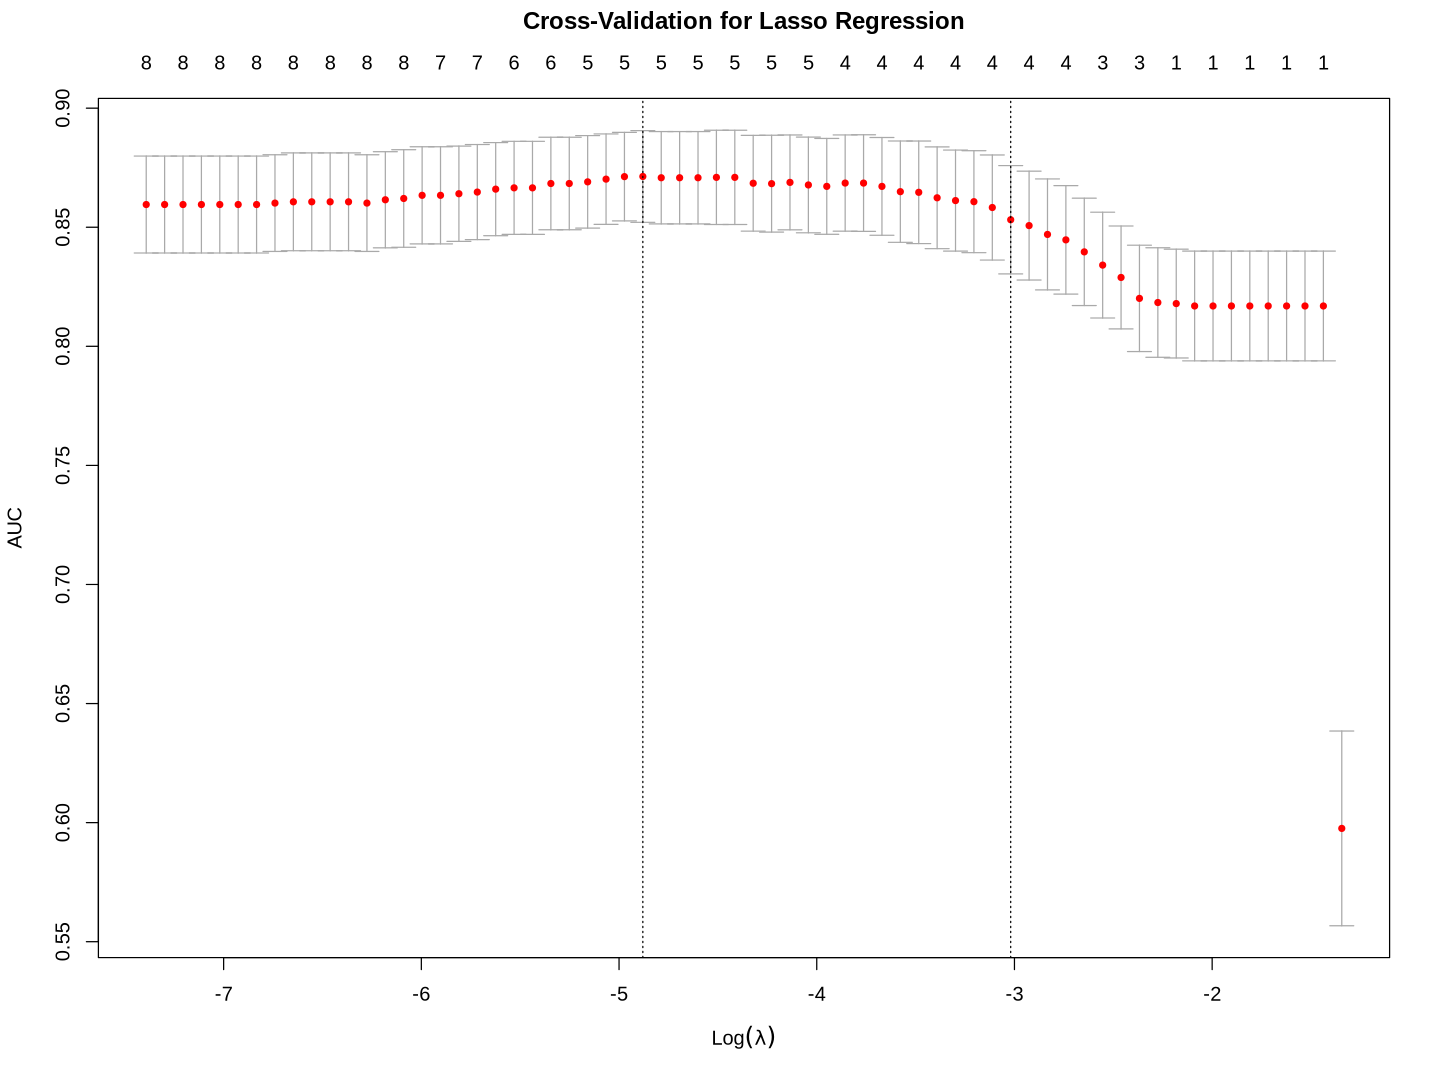

In [17]:
# LASSO REGRESSION CROSS VALIDATION
set.seed(123)

# Ridge cross-validation
lambda_lasso <- cv.glmnet(
  x = diabetes_X_train, 
  y = diabetes_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10
)

plot(lambda_lasso, 
     main = "Cross-Validation for Lasso Regression\n\n")

# extracting the lambda value that gives the maximum AUC
lambda_best_lasso <- lambda_lasso$lambda.min
cat("Best Lambda for Ridge:", lambda_best_lasso, "\n")

In [18]:
# FITTING LASSO REGRESSION WITH THE BEST LAMBDA
lasso_max_auc <- glmnet(
  x = diabetes_X_train, 
  y = diabetes_Y_train,
  alpha = 1,
  family = "binomial",
  lambda = lambda_best_lasso
)

coef(lasso_max_auc)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -9.720173210
Pregnancies               .          
Glucose                   0.039856526
BloodPressure             .          
SkinThickness             0.002937442
Insulin                   .          
BMI                       0.067524988
DiabetesPedigreeFunction  0.938915631
Age                       0.035281285

In [19]:
# CALCULATE AUC FOR LASSO

lasso_preds <- predict(lasso_max_auc, newx = diabetes_X_test, type = "response")
lasso_auc <- roc(diabetes_Y_test, as.vector(lasso_preds))$auc
cat("AUC for Lasso Regression:", lasso_auc, "\n")

Setting levels: control = 0, case = 1

Warning message in roc.default(diabetes_Y_test, as.vector(lasso_preds)):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases



AUC for Lasso Regression: 0.8068847 


### Comparing

In [20]:
AUC_models <- tibble(
  model = c("Ordinary Logistic Regression", "Ridge Regression", "Lasso Regression"),
  auc = c(cv_ordinary_auc, ridge_auc, lasso_auc)
)

print(AUC_models)

# A tibble: 3 × 2
  model                          auc
  <chr>                        <dbl>
1 Ordinary Logistic Regression 0.856
2 Ridge Regression             0.815
3 Lasso Regression             0.807


Setting levels: control = 0, case = 1

Warning message in roc.default(diabetes_Y_test, ordinary_preds):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(diabetes_Y_test, as.vector(ridge_preds)):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(diabetes_Y_test, as.vector(lasso_preds)):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases



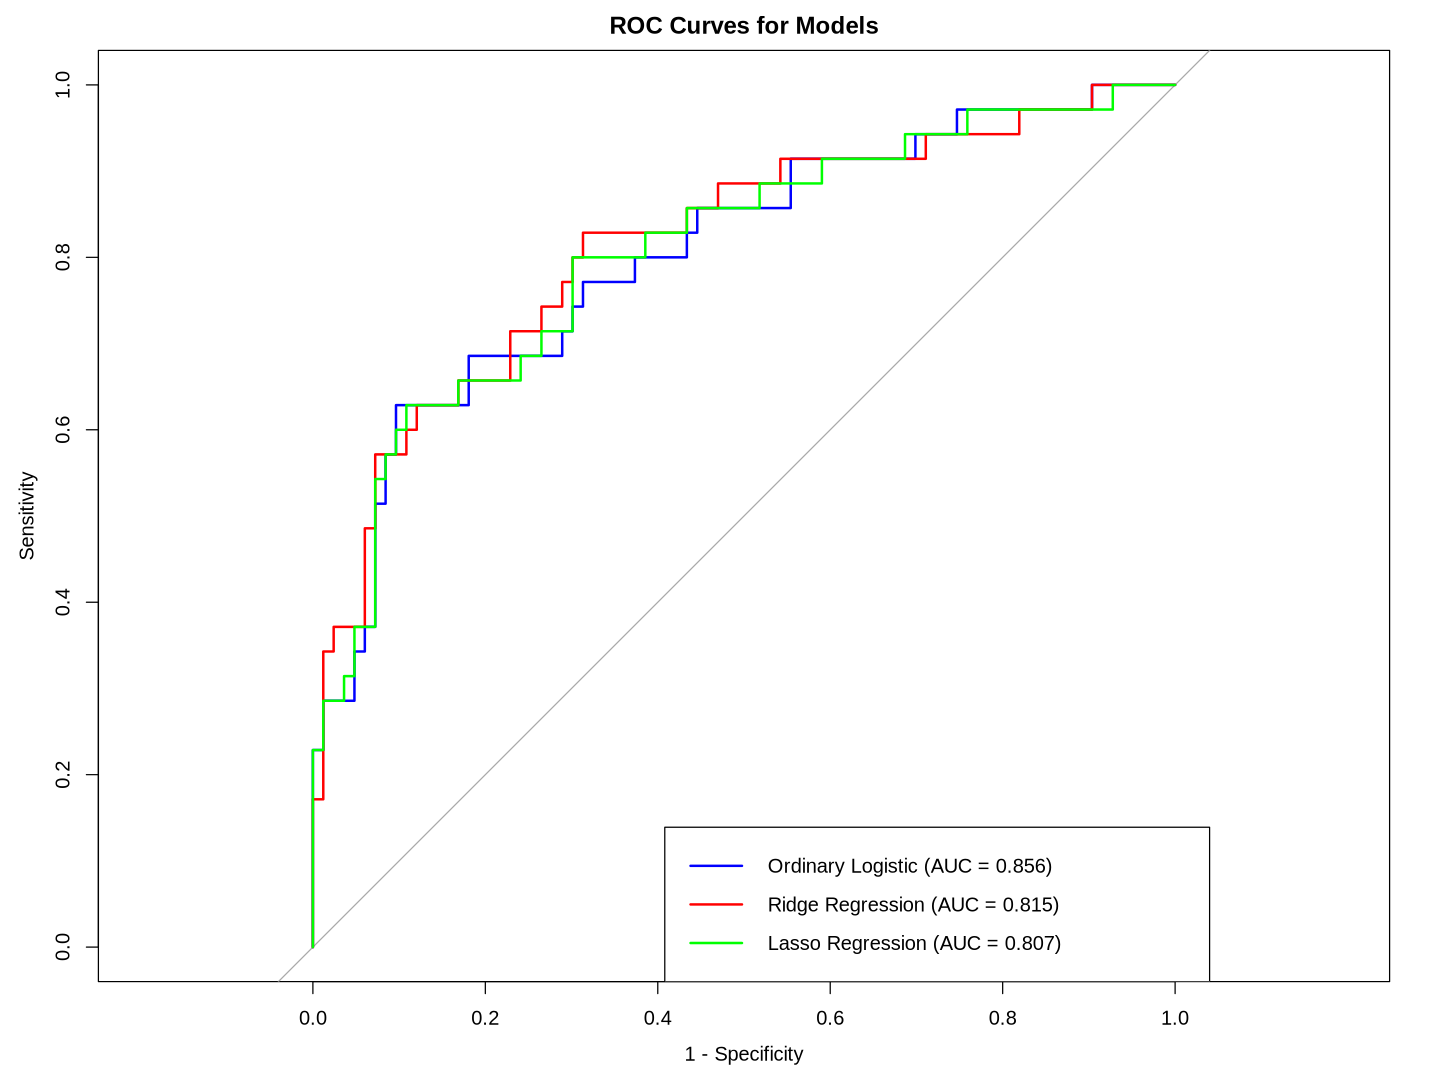

In [24]:
# Ordinary Logistic Regression Predictions
ordinary_preds <- predict(glm(Outcome ~ ., data = training_diabetes, family = "binomial"), 
                          newdata = testing_diabetes, type = "response")
roc_ordinary <- roc(diabetes_Y_test, ordinary_preds)

roc_ridge <- roc(diabetes_Y_test, as.vector(ridge_preds))
roc_lasso <- roc(diabetes_Y_test, as.vector(lasso_preds))

plot(roc_ordinary, col = "blue", lwd = 2, main = "ROC Curves for Models", legacy.axes = TRUE)
plot(roc_ridge, col = "red", lwd = 2, add = TRUE)
plot(roc_lasso, col = "green", lwd = 2, add = TRUE)

legend("bottomright", 
       legend = c("Ordinary Logistic (AUC = 0.856)", 
                  "Ridge Regression (AUC = 0.815)", 
                  "Lasso Regression (AUC = 0.807)"),
       col = c("blue", "red", "green"), 
       lwd = 2)

>
> 
>
>
>
>
>
>
>
>

# Discussion

# References